# QSAR of Amyloid Beta (Abeta) - Computational Drug Discovery #
***
## Part 2 - Data Analysis ##

## Load Bioactivity Data from Part One ##

In [1]:
%matplotlib widget

In [2]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
import mplcursors #datapoint selection and identification from graphs (like Grace for UNIX)

In [3]:
df = pd.read_csv('/Users/noahzeidenberg/Documents/Documents/School/Drug Discovery/Abeta_bioactivity_preprocessed_data.csv')
df.head(3)

molecule_chembl_id                   canonical_smiles  standard_value  \
0        CHEMBL81260  CN(C)c1ccc(-c2cn3cc(Br)ccc3n2)cc1        23.09878   
1        CHEMBL55380   CN(C)c1ccc(-c2nc3ccc(I)cc3s2)cc1         2.01834   
2        CHEMBL78410      CNc1ccc(-c2cn3cc(C)ccc3n2)cc1      4485.20000   

  standard_type   bioact_class  
0         aIC50  highly active  
1         aIC50  highly active  
2         aIC50   intermediate

## Calculate Lipinski Descriptors ##
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [4]:
# improved code inspired by @dataprofessor (who was inspired by https://codeocean.com/explore/capsules?query=tag:data-curation)
# this code is cleaner and *should* be more efficient (though I have yet to compare run times)
# It was suggested that I use progress bars from tqdm more frequently in my work, so I will begin to include those as well.

def lipinski(smiles, verbose=False):

    descriptors_data = []
    for element in tqdm(smiles, desc="Processing SMILES strings"):
        
        mol = Chem.MolFromSmiles(element)
        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHdonor = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        descriptors_data.append([desc_MolWt, desc_MolLogP, desc_NumHdonor, desc_NumHAcceptors])

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(descriptors_data, columns=columnNames)

    return descriptors

In [5]:
df_lipinski = lipinski(df.canonical_smiles)

Processing SMILES strings: 100%|██████████| 1817/1817 [00:01<00:00, 1604.85it/s]


In [6]:
df_lipinski

MW     LogP  NumHDonors  NumHAcceptors
0     316.202  3.82980           0              3
1     380.254  4.63390           0              3
2     237.306  3.35142           1              3
3     223.279  3.04300           1              3
4     251.333  3.37572           0              3
...       ...      ...         ...            ...
1812  360.377  4.03670           2              6
1813  360.377  3.33790           1              7
1814  256.349  2.82622           2              3
1815  325.456  3.16612           1              4
1816  323.440  4.06230           1              3

[1817 rows x 4 columns]

Let's create a new df with lipinski descriptors as well as bioactivity.

In [7]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head(10)

molecule_chembl_id                   canonical_smiles  standard_value  \
0        CHEMBL81260  CN(C)c1ccc(-c2cn3cc(Br)ccc3n2)cc1        23.09878   
1        CHEMBL55380   CN(C)c1ccc(-c2nc3ccc(I)cc3s2)cc1         2.01834   
2        CHEMBL78410      CNc1ccc(-c2cn3cc(C)ccc3n2)cc1      4485.20000   
3        CHEMBL81685         CNc1ccc(-c2cn3ccccc3n2)cc1      2242.60000   
4        CHEMBL78621   Cc1ccc2nc(-c3ccc(N(C)C)cc3)cn2c1       542.70920   
5       CHEMBL312622      CN(C)c1ccc(-c2cn3ccccc3n2)cc1      4485.20000   
6       CHEMBL310444  CN(C)c1ccc(-c2nc3ccc(I)cn3c2I)cc1      4485.20000   
7        CHEMBL78765      Cc1ccc2nc(-c3ccc(Br)cc3)cn2c1      1430.77880   
8       CHEMBL309920  CN(C)c1ccc2nc(-c3ccc(Br)cc3)cn2c1       760.24140   
9        CHEMBL78012   CN(C)c1ccc(-c2cn3cc(I)ccc3n2)cc1        33.63900   

  standard_type   bioact_class       MW     LogP  NumHDonors  NumHAcceptors  
0         aIC50  highly active  316.202  3.82980           0              3  
1         aIC50  highly active  380.254  4.63390           0              3  
2         aIC50   intermediate  237.306  3.35142           1              3  
3         aIC50   intermediate  223.279  3.04300           1              3  
4         aIC50         active  251.333  3.37572           0              3  
5         aIC50   intermediate  237.306  3.06730           0              3  
6         aIC50   intermediate  489.098  4.27650           0              3  
7         aIC50   intermediate  287.160  4.07222           0              2  
8         aIC50         active  316.202  3.82980           0              3  
9         aIC50  highly active  363.202  3.67190           0              3

In [8]:
# Normalize standard_value by capping it at 10^8, and ensuring all values are positive
epsilon = sys.float_info.epsilon

def normalize_standard_value(data):
    data['standard_value_norm'] = data['standard_value'].clip(lower = epsilon, upper=100000000) #using epsilon to be the numerical equivalent to "lim -> 0+"
    
    # Drop the 'standard_value' column
    data = data.drop('standard_value', axis=1)
    
    return data

In [9]:
df_norm = normalize_standard_value(df_combined)

In [10]:
# Convert to pIC50
def to_pIC50(data):

    # Convert nM to M and then calculate pIC50
    data['pIC50'] = -np.log10(data['standard_value_norm'].astype(float) * 1e-9)
    
    # Drop the 'standard_value_norm' column
    data = data.drop('standard_value_norm', axis=1)
    
    return data
        
    return x

In [11]:
df_final = to_pIC50(df_norm)
df_final

molecule_chembl_id                                   canonical_smiles  \
0           CHEMBL81260                  CN(C)c1ccc(-c2cn3cc(Br)ccc3n2)cc1   
1           CHEMBL55380                   CN(C)c1ccc(-c2nc3ccc(I)cc3s2)cc1   
2           CHEMBL78410                      CNc1ccc(-c2cn3cc(C)ccc3n2)cc1   
3           CHEMBL81685                         CNc1ccc(-c2cn3ccccc3n2)cc1   
4           CHEMBL78621                   Cc1ccc2nc(-c3ccc(N(C)C)cc3)cn2c1   
...                 ...                                                ...   
1812      CHEMBL5174252  O=[N+]([O-])c1ccc2nc3c(c(Nc4[nH]nc5ncccc45)c2c...   
1813      CHEMBL5205489  Nc1nn(-c2c3c(nc4ccc([N+](=O)[O-])cc24)CCCC3)c2...   
1814      CHEMBL5190530                      Cc1ccc2nc3c(c(NCCO)c2c1)CCCC3   
1815      CHEMBL5199187               Cc1ccc2nc3c(c(NCCN4CCOCC4)c2c1)CCCC3   
1816      CHEMBL5185354            CC(=O)Nc1ccc2nc3c(c(N4CCCCC4)c2c1)CCCC3   

     standard_type   bioact_class       MW     LogP  NumHDonors  \
0            aIC50  highly active  316.202  3.82980           0   
1            aIC50  highly active  380.254  4.63390           0   
2            aIC50   intermediate  237.306  3.35142           1   
3            aIC50   intermediate  223.279  3.04300           1   
4            aIC50         active  251.333  3.37572           0   
...            ...            ...      ...      ...         ...   
1812          IC50         active  360.377  4.03670           2   
1813          IC50       inactive  360.377  3.33790           1   
1814          IC50   intermediate  256.349  2.82622           2   
1815          IC50       inactive  325.456  3.16612           1   
1816          IC50   intermediate  323.440  4.06230           1   

      NumHAcceptors     pIC50  
0                 3  7.636411  
1                 3  8.695006  
2                 3  5.348218  
3                 3  5.649248  
4                 3  6.265433  
...             ...       ...  
1812              6  6.109579  
1813              7  4.498120  
1814              3  5.529590  
1815              4  4.822752  
1816              3  5.885056  

[1817 rows x 9 columns]

In [12]:
df_final['pIC50'].describe()

count    1817.000000
mean        6.204992
std         1.473068
min         4.000000
25%         5.000000
50%         5.950278
75%         7.327902
max        24.653560
Name: pIC50, dtype: float64

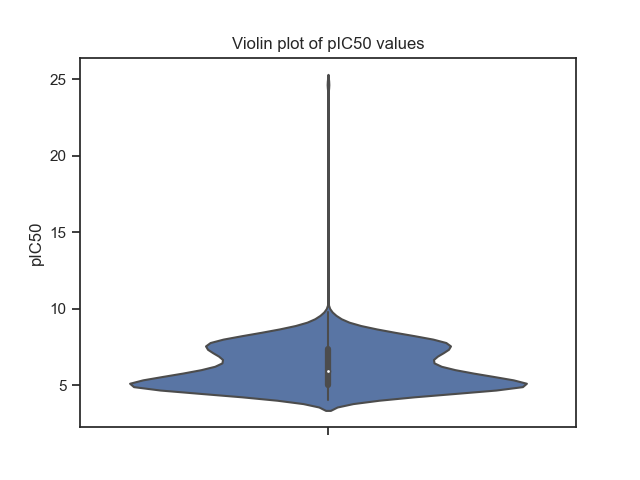

In [13]:
# Violin plot
sns.violinplot(y=df_final['pIC50'])
plt.ylabel('pIC50')
plt.title('Violin plot of pIC50 values')

# Enable interactive data cursor
mplcursors.cursor(hover=True)

plt.show()

In [14]:
count = (df_final['pIC50'] > 10).sum()
count

2

For the pIC50 distribution, it appears to be contained within 4-10 log units.

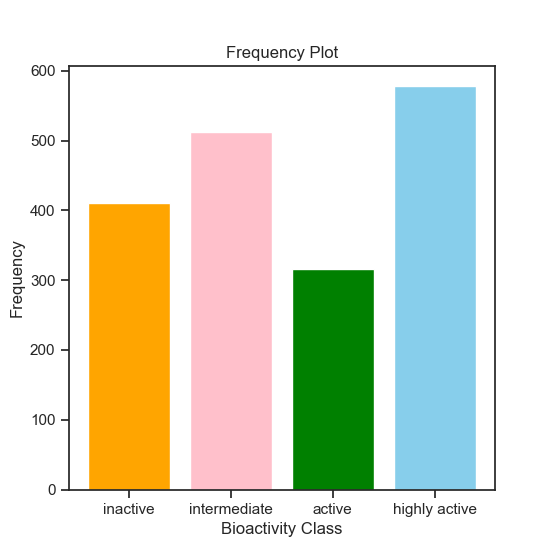

In [15]:
plt.figure(figsize=(5.5, 5.5))

# Compute the frequency (count) for each category
frequency = df_final['bioact_class'].value_counts()

# Specify desired order
order = ['inactive', 'intermediate', 'active', 'highly active']
frequency_ordered = frequency.reindex(order)

# Create the bar plot
plt.bar(frequency_ordered.index, frequency_ordered.values, color=['orange', 'pink', 'green', 'skyblue'])

# Title and labels
plt.title('Frequency Plot')
plt.xlabel('Bioactivity Class')
plt.ylabel('Frequency')

# Display the plot
plt.show()

plt.savefig('plot1_bioactivity_class.pdf')

## Scatterplot of MW vs. LogP ##

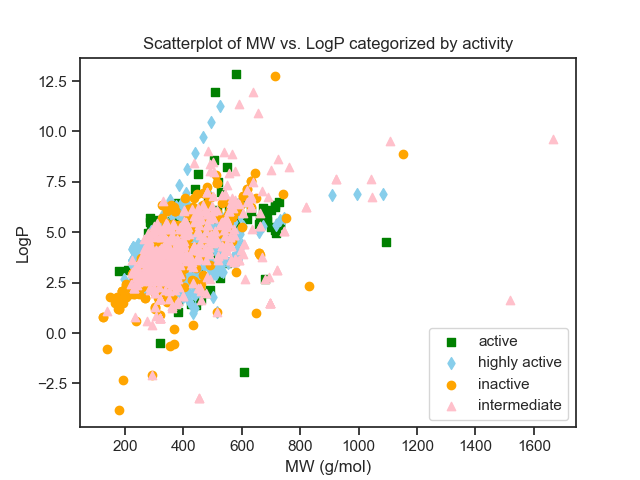

In [16]:
fig, ax = plt.subplots()

# Define color and marker mappings for categories
color_map = {
    'inactive': 'orange',
    'intermediate': 'pink',
    'active': 'green',
    'highly active': 'skyblue'
}

marker_map = {
    'inactive': 'o', #circle
    'intermediate': '^', #triangle
    'active': 's',  # square
    'highly active': 'd' #diamond
}

# Plot data points by category
for category, group in df_final[['bioact_class','MW', 'LogP']].groupby('bioact_class'):
    ax.scatter(group['MW'], group['LogP'], 
               color=color_map[category], 
               marker=marker_map[category], 
               label=category)

# Title, labels and legend
ax.set_title('Scatterplot of MW vs. LogP categorized by activity')
ax.set_xlabel('MW (g/mol)')
ax.set_ylabel('LogP')
ax.legend(loc='best')

plt.show()

I see why @dataprofessor removed the intermediate category. I will keep it for training the model.
Furthermore, with matplotlib we can see multiple plots together. It seems more interpretable with four separate plots:

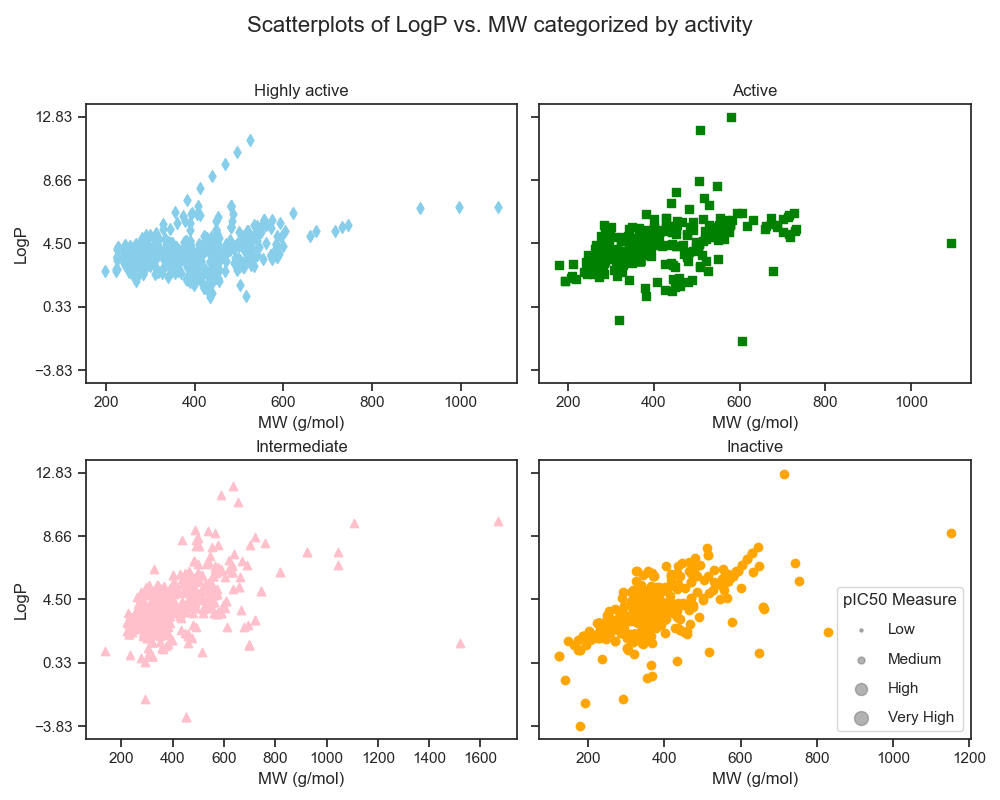

In [17]:
def subscatterplots(data, size=[None]*4):
    
    # Create individual category variables for readability
    df_hiactive = data[data['bioact_class'] == 'highly active']
    df_active = data[data['bioact_class'] == 'active']
    df_intermediate = data[data['bioact_class'] == 'intermediate']
    df_inactive = data[data['bioact_class'] == 'inactive']
    
    # Determine global min and max for 'LogP' across all subsets
    global_min = min(df_hiactive['LogP'].min(), df_active['LogP'].min(), df_inactive['LogP'].min(), df_intermediate['LogP'].min())
    global_max = max(df_hiactive['LogP'].max(), df_active['LogP'].max(), df_inactive['LogP'].max(), df_intermediate['LogP'].max())
    
    # Generate evenly spaced ticks between global_min and global_max, so all the graphs are on the same y-axis
    yticks = np.linspace(global_min, global_max, 5) 
    
    # Create the figure and a 2x2 grid for axs
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    
    # Plot data for each category
    axs[0, 0].scatter(df_hiactive['MW'], df_hiactive['LogP'], color='skyblue', marker='d', s=size[0])
    axs[0, 0].set_title('Highly active')
    axs[0, 0].set_xlabel('MW (g/mol)')
    axs[0, 0].set_ylabel('LogP')
    axs[0, 0].set_yticks(yticks)

    # Define a list of sizes and labels for the legend
    # Here I'm defining arbitrary sizes and labels, but you can adjust them
    sizes_for_legend = [5, 25, 75, 100]
    labels = ["Low", "Medium", "High", "Very High"]
    
    # Create dummy scatter plots for legend on the main figure
    for s, label in zip(sizes_for_legend, labels):
        plt.scatter([], [], c='gray', alpha=0.6, s=s, label=label)

    # Add a legend on the main figure
    plt.legend(loc="lower right", scatterpoints=1, frameon=True, labelspacing=1, title="pIC50 Measure")
    
    axs[0, 1].scatter(df_active['MW'], df_active['LogP'], color='green', marker='s', s=size[1])
    axs[0, 1].set_title('Active')
    axs[0, 1].set_xlabel('MW (g/mol)')
    axs[0, 1].set_yticks(yticks)
    
    axs[1, 0].scatter(df_intermediate['MW'], df_intermediate['LogP'], color='pink', marker='^', s=size[2])
    axs[1, 0].set_title('Intermediate')
    axs[1, 0].set_xlabel('MW (g/mol)')
    axs[1, 0].set_ylabel('LogP')
    axs[1, 0].set_yticks(yticks)
    
    axs[1, 1].scatter(df_inactive['MW'], df_inactive['LogP'], color='orange', marker='o', s=size[3])
    axs[1, 1].set_title('Inactive')
    axs[1, 1].set_xlabel('MW (g/mol)')
    axs[1, 1].set_yticks(yticks)
    
    # Add a main title to the figure
    fig.suptitle('Scatterplots of LogP vs. MW categorized by activity', fontsize=16)
    
    # Adjust layout
    fig.tight_layout(pad=0.8)
    fig.subplots_adjust(top=0.87)

    plt.show()

# Call the function
subscatterplots(df_final)

For readability, and for the sake of the y-axis, remove outliers based on IQR:

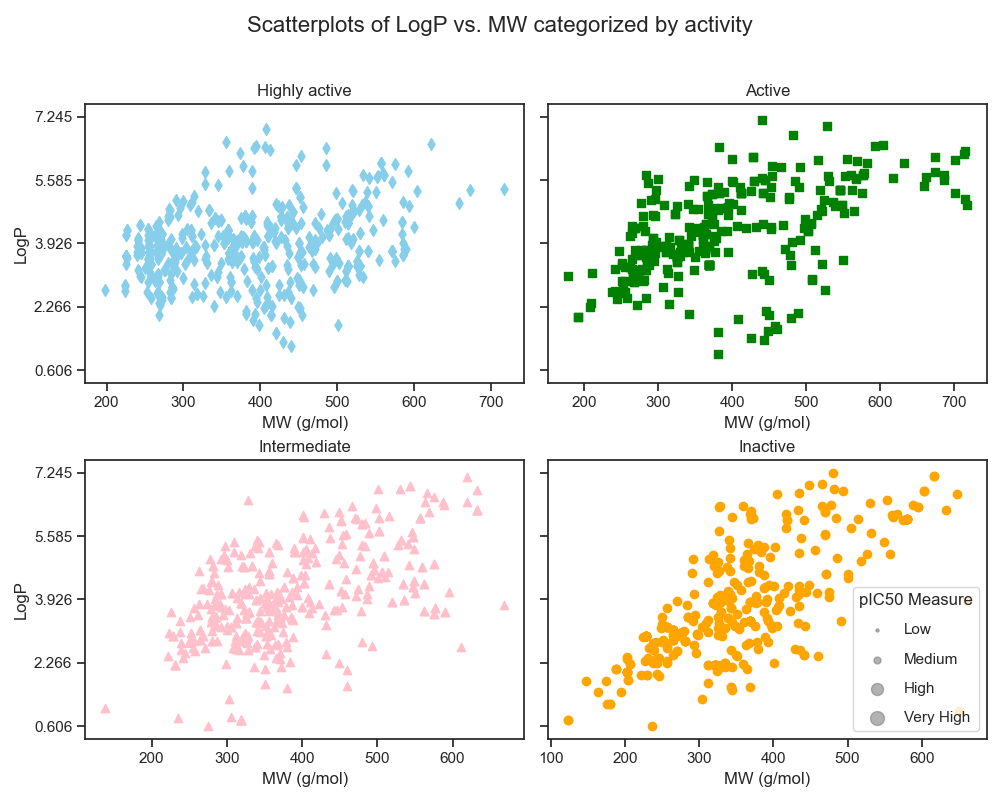

In [34]:
# Calculate Q1, Q3 and IQR for MW, LogP, # H donor/acceptors
Q1_MW = df_final['MW'].quantile(0.25)
Q3_MW = df_final['MW'].quantile(0.75)
IQR_MW = Q3_MW - Q1_MW

Q1_LogP = df_final['LogP'].quantile(0.25)
Q3_LogP = df_final['LogP'].quantile(0.75)
IQR_LogP = Q3_LogP - Q1_LogP

Q1_NumHDonors = df_final['NumHDonors'].quantile(0.25)
Q3_NumHDonors = df_final['NumHDonors'].quantile(0.75)
IQR_NumHDonors = Q3_NumHDonors - Q1_NumHDonors

Q1_NumHAcceptors = df_final['NumHAcceptors'].quantile(0.25)
Q3_NumHAcceptors = df_final['NumHAcceptors'].quantile(0.75)
IQR_NumHAcceptors = Q3_NumHAcceptors - Q1_NumHAcceptors

# Define bounds
lower_bound_MW = Q1_MW - 1.5 * IQR_MW
upper_bound_MW = Q3_MW + 1.5 * IQR_MW

lower_bound_LogP = Q1_LogP - 1.5 * IQR_LogP
upper_bound_LogP = Q3_LogP + 1.5 * IQR_LogP

lower_bound_NumHDonors = Q1_NumHDonors - 1.5 * IQR_NumHDonors
upper_bound_NumHDonors = Q3_NumHDonors + 1.5 * IQR_NumHDonors

lower_bound_NumHAcceptors = Q1_NumHAcceptors - 1.5 * IQR_NumHAcceptors
upper_bound_NumHAcceptors = Q3_NumHAcceptors + 1.5 * IQR_NumHAcceptors

#print("IQR_MW", IQR_MW)
#print("IQR_LogP", IQR_LogP)
#print("lower_MW", lower_bound_MW)
#print("higher_MW", upper_bound_MW)
#print("lower_LogP", lower_bound_LogP)
#print("higher_LogP", upper_bound_LogP)


# Remove Lipinski outliers
df_filtered = df_final[(df_final['MW'] >= lower_bound_MW) & (df_final['MW'] <= upper_bound_MW) \
                    & (df_final['LogP'] >= lower_bound_LogP) & (df_final['LogP'] <= upper_bound_LogP) \
                    & (df_final['NumHDonors'] >= lower_bound_NumHDonors) & (df_final['NumHDonors'] <= upper_bound_NumHDonors) \
                    & (df_final['NumHAcceptors'] >= lower_bound_NumHAcceptors) & (df_final['NumHAcceptors'] <= upper_bound_NumHAcceptors)]

# Remove pIC50 outliers
df_filtered = df_filtered[(df_filtered['pIC50'] <= 10)]
df_filtered.to_csv('Abeta_bioactivity_ML_data.csv', index=False)

# Run again:
subscatterplots(df_filtered)

In [20]:
print("Number of outliers removed: ", df_final.shape[0]-df_filtered.shape[0])

Number of outliers removed:  213


And now we can include factors in the details of the graphs as size variables (e.g. with pIC50).

In [21]:
# For readability
hiactive = lambda: df_filtered['bioact_class'] == 'highly active'
active = lambda: df_filtered['bioact_class'] == 'active'
intermediate = lambda: df_filtered['bioact_class'] == 'intermediate'
inactive = lambda: df_filtered['bioact_class'] == 'inactive'

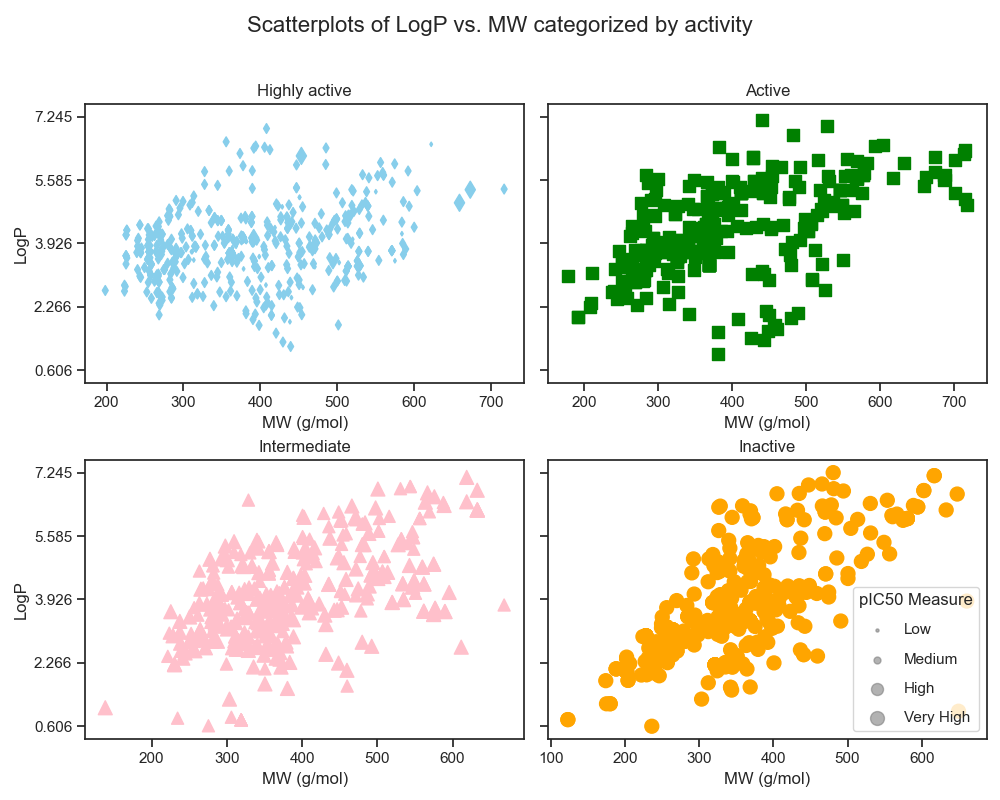

In [22]:
# Define bins and labels for categorizing the size based on pIC50 values
pIC_bins = [4, 5.5, 7, 8.5, 10]    # pIC50s range from 4-10, create 5 bins
pIC_labels = [100, 75, 25, 5]  # sizes for each bin (4-5.5, 5.5-7,...)

# pIC50 ordinals for each subset
size_hiactive = pd.cut(df_filtered[hiactive()]['pIC50'], bins=pIC_bins, labels=pIC_labels).astype(float).tolist()
size_active = pd.cut(df_filtered[active()]['pIC50'], bins=pIC_bins, labels=pIC_labels).astype(float).tolist()
size_intermediate = pd.cut(df_filtered[intermediate()]['pIC50'], bins=pIC_bins, labels=pIC_labels).astype(float).tolist()
size_inactive = pd.cut(df_filtered[inactive()]['pIC50'], bins=pIC_bins, labels=pIC_labels).astype(float).tolist()

sizes = [size_hiactive, size_active, size_intermediate, size_inactive]

# Added the optional size specifier knowing we'd use it later
subscatterplots(df_filtered, sizes)

- cannot assume a normal distribution like t-test
- can instead investigate the **differences in rank-sums** of each idependant group, and their central tendency -> perform a non-parametric test (e.g. Kruskal-Wallis test)

In [23]:
# kruskal-wallis test for pIC50 data

# Assign each value a rank from lowest (1) to highest
df_filtered['pIC_ranks'] = df_filtered['pIC50'].rank().astype(int)
#print(df_filtered[['pIC50', 'ranks']])

# Get the rank sum for each group

# For the highly active group:
hiactive_ranksum = df_filtered[hiactive()]['pIC_ranks'].sum()

active_ranksum = df_filtered[active()]['pIC_ranks'].sum()
intermediate_ranksum = df_filtered[intermediate()]['pIC_ranks'].sum()
inactive_ranksum = df_filtered[inactive()]['pIC_ranks'].sum()

KW_pIC50 = df_filtered.groupby('bioact_class')['pIC_ranks'].sum().reset_index().rename(columns={'pIC_ranks':'rank sum'})
#print(df_ranks, "\n")

# Get mean of the rank sum

hiactive_rankmean = df_filtered[hiactive()]['pIC_ranks'].mean()
active_rankmean = df_filtered[active()]['pIC_ranks'].mean()
intermediate_rankmean = df_filtered[intermediate()]['pIC_ranks'].mean()
inactive_rankmean = df_filtered[inactive()]['pIC_ranks'].mean()

df_means = df_filtered.groupby('bioact_class')['pIC_ranks'].mean().reset_index().rename(columns={'pIC_ranks' : 'pIC_means'})
#print(df_means)

KW_pIC50['means'] = df_means['pIC_means']
print(KW_pIC50)

    bioact_class  rank sum        means
0         active    269066   899.886288
1  highly active    736381  1326.812613
2       inactive     57925   170.367647
3   intermediate    223585   545.329268


### Kruskal Wallis test for Lipinski Descriptors ###

In [24]:
# Assign each value a rank from lowest (1) to highest ##
df_filtered['MW_ranks'] = df_filtered['MW'].rank().astype(int)   #MW
df_filtered['LogP_ranks'] = df_filtered['LogP'].rank().astype(int) #LogP
df_filtered['Hdonor_ranks'] = df_filtered['NumHDonors'].rank().astype(int) #H-donors
df_filtered['Hacc_ranks'] = df_filtered['NumHAcceptors'].rank().astype(int) #H-acceptors

In [25]:
# Get the rank sums for each group

MW_bioranks = df_filtered.groupby('bioact_class')['MW_ranks'].sum().reset_index().rename(columns={'MW_ranks':'MW_ranksum'})
LogP_bioranks = df_filtered.groupby('bioact_class')['LogP_ranks'].sum().reset_index().rename(columns={'LogP_ranks':'LogP_ranksum'})
Hdonor_bioranks = df_filtered.groupby('bioact_class')['Hdonor_ranks'].sum().reset_index().rename(columns={'Hdonor_ranks':'Hdonor_ranksum'})
Hacc_bioranks = df_filtered.groupby('bioact_class')['Hacc_ranks'].sum().reset_index().rename(columns={'Hacc_ranks':'Hacc_ranksum'})

# Get the rank means for each group
MW_means = df_filtered.groupby('bioact_class')['MW_ranks'].mean().reset_index().rename(columns={'MW_ranks': 'MW_means'})
MW_bioranks['MW_means'] = MW_means['MW_means']

LogP_means = df_filtered.groupby('bioact_class')['LogP_ranks'].mean().reset_index().rename(columns={'LogP_ranks': 'LogP_means'})
LogP_bioranks['LogP_means'] = LogP_means['LogP_means']

Hdonor_means = df_filtered.groupby('bioact_class')['Hdonor_ranks'].mean().reset_index().rename(columns={'Hdonor_ranks': 'Hdonor_means'})
Hdonor_bioranks['Hdonor_means'] = Hdonor_means['Hdonor_means']

Hacc_means = df_filtered.groupby('bioact_class')['Hacc_ranks'].mean().reset_index().rename(columns={'Hacc_ranks': 'Hacc_means'})
Hacc_bioranks['Hacc_means'] = Hacc_means['Hacc_means']

# Combine into one dataframe
Bioranks_means_df = pd.merge(MW_bioranks, LogP_bioranks).merge(Hdonor_bioranks).merge(Hacc_bioranks)
Bioranks_means_df

bioact_class  MW_ranksum    MW_means  LogP_ranksum  LogP_means  \
0         active      255133  853.287625        277572  928.334448   
1  highly active      457479  824.286486        438093  789.356757   
2       inactive      233806  687.664706        237291  697.914706   
3   intermediate      340478  830.434146        333965  814.548780   

   Hdonor_ranksum  Hdonor_means  Hacc_ranksum  Hacc_means  
0          208077    695.909699        234021  782.678930  
1          397535    716.279279        447381  806.091892  
2          317860    934.882353        257420  757.117647  
3          363455    886.475610        347719  848.095122

Note that the expected sum $\mathbb{E}[X]$ of a set of random numbers
$
(x_i, x_{i+1}, ..., n) 
$ is:

$$ \mathbb{E}[X] = \dfrac{n+1}{2} $$

And the expected variance is:
$$
\mathbb{E}[X^2] - (\mathbb{E}[X])^2
$$

where
$ \mathbb{E}[X^2] $ is the expected value of the square of a randomly chosen number from the set. Then:

$$
\mathbb{E}[X^2] = \frac{\sum_{i=1}^{n} i^2}{n} = \dfrac{n(n+1)(2n+1)}{6n}
$$
The variance can be computed as,
$$
\text{Var} = \dfrac{(n+1)(2n+1)}{6} - (\dfrac{n+1}{2})^2 \\
\text{Var} = 2(n+1)(2n+1) - 3(n^2 +2n +1)
$$
Expanding and simplifying results in:
$$ \dfrac{n^2-1}{n} $$
where *n* is the total count of numbers in the set.

In [26]:
val_expec = (df_filtered.shape[0]+1)/2
degrees_freedom = 3 # 4 bioact_classes - 1.
var_expec = ((df_filtered.shape[0]**2)-1)/df_filtered.shape[0]    #using df_filtered.shape[0]. instead of ""[0] for float

To derive the formula for the expected rank, where each number *i* in a set $ S = {i_1, i_2, ..., n} $ ranked from smallest to largest:

If each observation has equal probability of getting any rank from 1 to N then
$$
\mathbb{E}[R] = \dfrac{\text{1,2,...,N}}{N} = \dfrac{(\dfrac{n(n+1)}{2})}{n} = \dfrac{n+1}{2}
$$
Likewise, consider an observation in the $\text{i}^\text{th}$ group, which has an equal chance of receiving any rank from {1,N} if randomly sampled. Then, the variance of its rank is equal to the variance for any observation in the set:
$$
\mathbb{E}(\sigma^2_R) = \dfrac{1}{n}\sum_{i=1}^{n} x_i^2 - [\dfrac{1}{n}\sum_{i=1}^n x_i]^2 = \dfrac{1}{n}\dfrac{n(n+1)(2n+1)}{6}-[\dfrac{n+1}{2}]^2 = \dfrac{n^2-1}{12}
$$

The test statistic *H* is represents:
$$
H = \dfrac{n-1}{12}\sum_{i=1}^{k} \dfrac{n_i (\bar{R_i}-\mathbb{E}_R)^2}{\mathbb{E}(\sigma_R^2)}
$$
where $ \bar{R_i} $ is the mean rank sum of individual groups,
and $ \mathbb{E}_R $ is the expected value of the ranks.

The null hypothesis ($ H = 0 $) for our use-case, is that the various bioactivity groups have similar distributions reflective of coming from the same population. The alternative hypothesis ($ H > 0 $) is that there is a statistically significant difference in the distributions across the four bioactivity rank groups.

Scipy.stats can perform the kruskal-wallis H-test:

In [27]:
from scipy.stats import kruskal

In [28]:
hiactivity_pIC50 = df_filtered[hiactive()]['pIC50'].reset_index(drop=True)
activity_pIC50 = df_filtered[active()]['pIC50'].reset_index(drop=True)
intermediate_pIC50 = df_filtered[intermediate()]['pIC50'].reset_index(drop=True)
inactivity_pIC50= df_filtered[inactive()]['pIC50'].reset_index(drop=True)

kruskal(hiactivity_pIC50, activity_pIC50, intermediate_pIC50, inactivity_pIC50)

KruskalResult(statistic=1484.2237186708476, pvalue=0.0)

In [29]:
# For the other Lipinski Descriptors:

MW_KW = kruskal(df_filtered[hiactive()]['MW'], df_filtered[active()]['MW'], \
        df_filtered[intermediate()]['MW'], df_filtered[inactive()]['MW'])


LogP_KW = kruskal(df_filtered[hiactive()]['LogP'], df_filtered[active()]['LogP'], \
        df_filtered[intermediate()]['LogP'], df_filtered[inactive()]['LogP'])

Hdonor_KW = kruskal(df_filtered[hiactive()]['NumHDonors'], df_filtered[active()]['NumHDonors'], \
        df_filtered[intermediate()]['NumHDonors'], df_filtered[inactive()]['NumHDonors'])


Hacc_KW = kruskal(df_filtered[hiactive()]['NumHAcceptors'], df_filtered[active()]['NumHAcceptors'], \
        df_filtered[intermediate()]['NumHAcceptors'], df_filtered[inactive()]['NumHAcceptors'])

print("Kruskal-Wallis test for Molecular Weight descriptor: \n", MW_KW, "\n")
print("Kruskal-Wallis test for Octanol-water partition coefficient descriptor: \n", LogP_KW, "\n")
print("Kruskal-Wallis test for # H-donors descriptor: \n", Hdonor_KW, "\n")
print("Kruskal-Wallis test for # H-acceptors descriptor: \n", Hacc_KW, "\n")

Kruskal-Wallis test for Molecular Weight descriptor: 
 KruskalResult(statistic=27.217113096198503, pvalue=5.301489672162969e-06) 

Kruskal-Wallis test for Octanol-water partition coefficient descriptor: 
 KruskalResult(statistic=40.12841092458673, pvalue=1.0007754792340263e-08) 

Kruskal-Wallis test for # H-donors descriptor: 
 KruskalResult(statistic=83.5900694669172, pvalue=5.2091852561051084e-18) 

Kruskal-Wallis test for # H-acceptors descriptor: 
 KruskalResult(statistic=8.078091691639505, pvalue=0.044425056838837386) 



The results of the Kruskal-Wallis H-test provides strong evidence against the null hypothesis. However, more tests must be done to identify which group(s) is/are so different.

I will perform the Conover-Iman test, which, like Dunn's test, is a good non-parametric post-hoc pairwise comparison after sufficient evidence against the null hypothesis with the Kruskal-Wallis H-test. The Conover-Iman test assumes stochastic dominance, while Dunn's test does not, but is gives more robust conclusions than Dunn's test. So, what is stochastic dominance and how can we know to make that assumption or not.

There are two orders of stochastic dominance.
1. **First-order Stochastic Dominance:** 
$$
P[A \ge x] \ge P[B \ge x] \text{ } \forall \text{ } x
$$

Distribution *A* is said to stochastically dominate *B* in the first order if, for any value *x*, the probability that *A* gives a value less than *x* is no greater than the corresponding probability for *B*. Graphically, the cumulative distribution function (CDF) of *A* is always to the left of or below the CDF of *B*.

2. **Second-order Stochastic Dominance:**
$$
\int_{-\infty}^{x} [F_B(t)-F_A(t)] dt \ge 0 \text{ } \forall \text{ } x
$$

*A* is said to have second-order dominance over *B* if the area under the CDF of *A* is always to the left of or below the CDF of *B* up to any value *x*.

Let's estimate the CDF that generated the points in each bioactivity group using empirical CDFs (ECDFs) to visualize the distributions of each descriptor group.

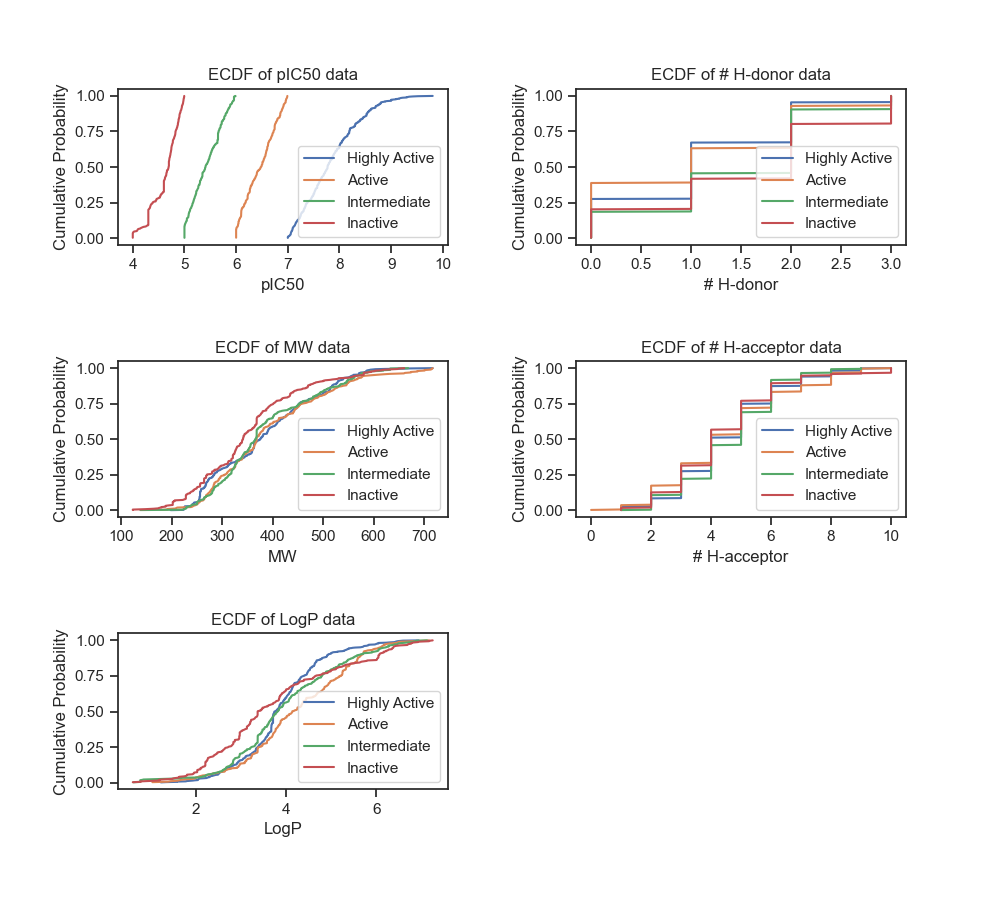

In [30]:
x1_1, y1_1 = np.sort(hiactivity_pIC50), np.arange(1, len(hiactivity_pIC50) + 1) / len(hiactivity_pIC50)
x2_1, y2_1 = np.sort(activity_pIC50), np.arange(1, len(activity_pIC50) + 1) / len(activity_pIC50)
x3_1, y3_1 = np.sort(intermediate_pIC50), np.arange(1, len(intermediate_pIC50) + 1) / len(intermediate_pIC50)
x4_1, y4_1 = np.sort(inactivity_pIC50), np.arange(1, len(inactivity_pIC50) + 1) / len(inactivity_pIC50)

x1_2, y1_2 = np.sort(df_filtered[hiactive()]['MW']), np.arange(1, len(df_filtered[hiactive()]['MW']) + 1) / len(df_filtered[hiactive()]['MW'])
x2_2, y2_2 = np.sort(df_filtered[active()]['MW']), np.arange(1, len(df_filtered[active()]['MW']) + 1) / len(df_filtered[active()]['MW'])
x3_2, y3_2 = np.sort(df_filtered[intermediate()]['MW']), np.arange(1, len(df_filtered[intermediate()]['MW']) + 1) / len(df_filtered[intermediate()]['MW'])
x4_2, y4_2 = np.sort(df_filtered[inactive()]['MW']), np.arange(1, len(df_filtered[inactive()]['MW']) + 1) / len(df_filtered[inactive()]['MW'])

x1_3, y1_3 = np.sort(df_filtered[hiactive()]['LogP']), np.arange(1, len(df_filtered[hiactive()]['LogP']) + 1) / len(df_filtered[hiactive()]['LogP'])
x2_3, y2_3 = np.sort(df_filtered[active()]['LogP']), np.arange(1, len(df_filtered[active()]['LogP']) + 1) / len(df_filtered[active()]['LogP'])
x3_3, y3_3 = np.sort(df_filtered[intermediate()]['LogP']), np.arange(1, len(df_filtered[intermediate()]['LogP']) + 1) / len(df_filtered[intermediate()]['LogP'])
x4_3, y4_3 = np.sort(df_filtered[inactive()]['LogP']), np.arange(1, len(df_filtered[inactive()]['LogP']) + 1) / len(df_filtered[inactive()]['LogP'])

x1_4, y1_4 = np.sort(df_filtered[hiactive()]['NumHDonors']), np.arange(1, len(df_filtered[hiactive()]['NumHDonors']) + 1) / len(df_filtered[hiactive()]['NumHDonors'])
x2_4, y2_4 = np.sort(df_filtered[active()]['NumHDonors']), np.arange(1, len(df_filtered[active()]['NumHDonors']) + 1) / len(df_filtered[active()]['NumHDonors'])
x3_4, y3_4 = np.sort(df_filtered[intermediate()]['NumHDonors']), np.arange(1, len(df_filtered[intermediate()]['NumHDonors']) + 1) / len(df_filtered[intermediate()]['NumHDonors'])
x4_4, y4_4 = np.sort(df_filtered[inactive()]['NumHDonors']), np.arange(1, len(df_filtered[inactive()]['NumHDonors']) + 1) / len(df_filtered[inactive()]['NumHDonors'])

x1_5, y1_5 = np.sort(df_filtered[hiactive()]['NumHAcceptors']), np.arange(1, len(df_filtered[hiactive()]['NumHAcceptors']) + 1) / len(df_filtered[hiactive()]['NumHAcceptors'])
x2_5, y2_5 = np.sort(df_filtered[active()]['NumHAcceptors']), np.arange(1, len(df_filtered[active()]['NumHAcceptors']) + 1) / len(df_filtered[active()]['NumHAcceptors'])
x3_5, y3_5 = np.sort(df_filtered[intermediate()]['NumHAcceptors']), np.arange(1, len(df_filtered[intermediate()]['NumHAcceptors']) + 1) / len(df_filtered[intermediate()]['NumHAcceptors'])
x4_5, y4_5 = np.sort(df_filtered[inactive()]['NumHAcceptors']), np.arange(1, len(df_filtered[inactive()]['NumHAcceptors']) + 1) / len(df_filtered[inactive()]['NumHAcceptors'])

# Create the figure and a 3x2 grid for axs
fig, axs = plt.subplots(3, 2, figsize=(10, 9))
fig.tight_layout(pad=5.0)

# Plot data for each category
axs[0,0].plot(x1_1, y1_1, label = 'Highly Active')
axs[0,0].plot(x2_1, y2_1, label='Active')
axs[0,0].plot(x3_1, y3_1, label='Intermediate')
axs[0,0].plot(x4_1, y4_1, label='Inactive')
axs[0,0].legend()
axs[0,0].set_xlabel('pIC50')
axs[0,0].set_ylabel('Cumulative Probability')
axs[0,0].set_title("ECDF of pIC50 data")

axs[1,0].plot(x1_2, y1_2, label = 'Highly Active')
axs[1,0].plot(x2_2, y2_2, label='Active')
axs[1,0].plot(x3_2, y3_2, label='Intermediate')
axs[1,0].plot(x4_2, y4_2, label='Inactive')
axs[1,0].legend()
axs[1,0].set_xlabel('MW')
axs[1,0].set_ylabel('Cumulative Probability')
axs[1,0].set_title("ECDF of MW data")

axs[2,0].plot(x1_3, y1_3, label = 'Highly Active')
axs[2,0].plot(x2_3, y2_3, label='Active')
axs[2,0].plot(x3_3, y3_3, label='Intermediate')
axs[2,0].plot(x4_3, y4_3, label='Inactive')
axs[2,0].legend()
axs[2,0].set_xlabel('LogP')
axs[2,0].set_ylabel('Cumulative Probability')
axs[2,0].set_title("ECDF of LogP data")

axs[0,1].plot(x1_4, y1_4, label = 'Highly Active')
axs[0,1].plot(x2_4, y2_4, label='Active')
axs[0,1].plot(x3_4, y3_4, label='Intermediate')
axs[0,1].plot(x4_4, y4_4, label='Inactive')
axs[0,1].legend()
axs[0,1].set_xlabel('# H-donor')
axs[0,1].set_ylabel('Cumulative Probability')
axs[0,1].set_title("ECDF of # H-donor data")

axs[1,1].plot(x1_5, y1_5, label = 'Highly Active')
axs[1,1].plot(x2_5, y2_5, label='Active')
axs[1,1].plot(x3_5, y3_5, label='Intermediate')
axs[1,1].plot(x4_5, y4_5, label='Inactive')
axs[1,1].legend()
axs[1,1].set_xlabel('# H-acceptor')
axs[1,1].set_ylabel('Cumulative Probability')
axs[1,1].set_title("ECDF of # H-acceptor data")

fig.delaxes(axs[2,1]) # Remove empty plot
plt.show()

The groups for MW and LogP are not consistently stochastically dominant, presented as the overlap between groups on the ECDF distributions. # H-acceptors and # H-donors appear to be stochastically dominant, so a test will be performed separately for them. 

The groups for pIC50 are stochastically dominant, so I will perform the Conover-Iman test. I will be using the 'p_adjust' specifier to perform Holm-Bonferroni step-down p-value adjustment in order to control for familywise error (probability of making at least one Type I error in a set of comparison tests).

The Conover-Iman test statistic is represented by:
$$
t = \dfrac{|\bar{R}_A - \bar{R}_B|}{\sqrt{(\dfrac{n(n+1)}{12})(\dfrac{n-1-H}{n-k})(\dfrac{1}{n_A}+\dfrac{1}{n_B})}}
$$

where k = number of groups, n = sample size and H is the test statistic from the Kruskal-Wallis test.

Note that $ H_0: P[x_A > x_B] = 0.5$

In [31]:
import scikit_posthocs as sp

In [32]:
Conover_pIC50 = sp.posthoc_conover([df_filtered[hiactive()]['pIC50'],df_filtered[active()]['pIC50'], df_filtered[intermediate()]['pIC50'],df_filtered[inactive()]['pIC50']], p_adjust='holm') 
#np.set_printoptions(precision=3)   #sp is a pandas df not np array
pd.options.display.float_format = '{:.3e}'.format #3 decimal places display format

print("Conover-Iman p-values for pIC50: \n", Conover_pIC50)

Conover-Iman p-values for pIC50: 
            1          2          3          4
1  1.000e+00 1.299e-304  0.000e+00  0.000e+00
2 1.299e-304  1.000e+00 1.630e-216  0.000e+00
3  0.000e+00 1.630e-216  1.000e+00 2.992e-247
4  0.000e+00  0.000e+00 2.992e-247  1.000e+00


The diagonal can be ignored, as it comparing groups to themselves. The upper and lower triangles reflect each other, so (1,2) and (2,1) are duplicates just like (2,4) and (4,2) are duplicates.

There is sufficient evidence to reject the null hypothesis for all ${4 \choose 2}$ (i.e. *6*) comparisons of pIC50 groups.

Now, testing # H-donors & # H-acceptors:

In [33]:
Conover_Hdon = sp.posthoc_conover([df_filtered[hiactive()]['NumHDonors'],df_filtered[active()]['NumHDonors'], df_filtered[intermediate()]['NumHDonors'],df_filtered[inactive()]['NumHDonors']], p_adjust='holm')
Conover_Hacc = sp.posthoc_conover([df_filtered[hiactive()]['NumHAcceptors'],df_filtered[active()]['NumHAcceptors'], df_filtered[intermediate()]['NumHAcceptors'],df_filtered[inactive()]['NumHAcceptors']], p_adjust='holm')
print("Conover-Iman p-values for # H-donors: \n", Conover_Hdon, "\n")
print("Conover-Iman p-values for # H-acceptors: \n", Conover_Hacc)

Conover-Iman p-values for # H-donors: 
           1         2         3         4
1 1.000e+00 5.118e-01 6.794e-09 1.735e-12
2 5.118e-01 1.000e+00 2.286e-08 2.031e-11
3 6.794e-09 2.286e-08 1.000e+00 2.513e-01
4 1.735e-12 2.031e-11 2.513e-01 1.000e+00 

Conover-Iman p-values for # H-acceptors: 
           1         2         3         4
1 1.000e+00 9.451e-01 4.726e-01 4.726e-01
2 9.451e-01 1.000e+00 2.937e-01 9.451e-01
3 4.726e-01 2.937e-01 1.000e+00 3.885e-02
4 4.726e-01 9.451e-01 3.885e-02 1.000e+00


The significance of the H-test statistic in the KW test for # H-donors came from the comparison of groups (highly active, intermediate), (highly active, inactive), (active, intermediate) and (active, inactive). Interestingly, we do not see a significant difference in the observed rank sums vs. expected rank sums for (highly active, active). Raising the cutoff between "highly active" and "active" would potentially change that, but seems uneccesary for the purposes of this project.

Notably, none of the p-values of the Conover-Iman test are significant for # H-acceptors. The KW H-statistic p-value of 0.044 was also quite large compared to the p-values in the ranges of $10^{-6}$ to $10^{-18}$ for the other Lipinski descriptors. So, **# H-acceptors will not be used as a descriptor to train the SVM**.

### Next, I will train an SVM on this data to predict structures based on pIC50 and Lipinski descriptors ###